Tyler Hinrichs \
STAT-4185 Final Project

### Objective
The objective of this project is to determine the features that best predict follower count on the music production/music sharing site audiotool.com. Audiotool has a page of its top artists listed in order of top followers. In this project, we will go through about 500 different artists, scraping info about their number of followers, number following, number of plays on the artist's top track, etc. We will use this to find out which factors influence artist follower count on the site most and can be used to predict follower count.

In [2]:
import requests
from bs4 import BeautifulSoup as bs

In [3]:
base_url = "https://www.audiotool.com/"
artists_page = "browse/users"

Below, we will use Selenium to access the main artists page. The site uses javascript to dynamically load its content, a common feature of many sites. Therefore, we will use Selenium to simulate page scrolls so that more content is loaded. When running this cell, we can see this happening automatically in real time. After, we will use Beautiful Soup to parse the raw HTML and start to gather data from it.

In [ ]:

from selenium import webdriver
import time
driver = webdriver.Chrome('/tmp/chromedriver')
driver.get(base_url+artists_page)

for i in range(30):
    driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
    time.sleep(3)

html = driver.page_source

In [ ]:
soup = bs(html, "html.parser")

In [5]:
usernames = []
num_followers = []
num_published_tracks = []
num_favorites = []
num_albums = []
num_following = []
num_wall_posts = []
time_since_joining = []
top_track_num_plays = []
top_track_num_favorites = []
top_track_genre = []

cols = [
num_followers,
num_published_tracks,
num_favorites,
num_albums,
num_following,
num_wall_posts,
time_since_joining,
top_track_num_plays,
top_track_num_favorites,
top_track_genre]

In [6]:
def getContent(element):
    return element.string

In [92]:
usernames = list(map(getContent, soup.select(".user-name-8")))

In [94]:
class ArtistError(Exception):
    pass

Below, we will start doing the process of scraping all the data. There are some accounts that are hidden to the public, meaning that you must login in order to see their profile. When running this script, by replacing the values in the "info" dictionary with your actual username and password, you will be able to scrape data from these hidden accounts. We will login with requests and begin parsing the html responses, using CSS selectors to grab data from precise tags. For each username in the list of artists from the main artists page referenced before, we will make a new request to access the artist's profile page, and then another to access their top track.
\
\
All important data will be appended to the appropriate list. If issues are encountered, such as encountering a deleted account or an account with no published tracks, -1 values will be appended to the lists, allowing us to clean the dataset more easily later. There are try/except statements set up to avoid issues of the script halting when encountering errors. After each attempt to scrape data from an artist, there is a brief explanation of the success of the scraping (whether is was successful, and if not, the reason if known).

In [204]:
from IPython.display import clear_output
counter = 0
error_counter = 0

offset = 0

# replace below with your audiotool credentials before running
info = {"username": "YOUR-AUDIOTOOL-USERNAME",
        "password": "YOUR-AUDIOTOOL-PASSWORD"}

for j in cols: j.clear()
with requests.Session() as s:
    s.post(base_url, data=info)
    for i in soup.select(".user-name-8")[offset:]:
        artist_url = i['href']
        artist_req = s.get(base_url+artist_url)
        artist_soup = bs(artist_req.content, 'html.parser')
        try:
            if artist_req.status_code == 404: raise ArtistError(f"Page not found: {usernames[offset+counter]}")
            if "Deleted" in list(map(getContent, artist_soup.select("h1"))): raise ArtistError(f"Account deleted: {usernames[offset+counter]}")
            if len(artist_soup.select("div._if-empty")) > 0: raise ArtistError(f"No published tracks: {usernames[offset+counter]}")
            tracks = artist_soup.select("#tab-nav > ul > li.tab-tracks.selected > a > span")
            num_published_tracks.append(tracks[0].string)

            favorites = artist_soup.select("#tab-nav > ul > li.tab-favorites > a > span")
            num_favorites.append(favorites[0].string)

            albums = artist_soup.select("#tab-nav > ul > li.tab-albums > a > span")
            num_albums.append(albums[0].string)

            wall = artist_soup.select("#tab-nav > ul > li.tab-wall > a > span")
            num_wall_posts.append(wall[0].string)

            followers = artist_soup.select("#header-content > div > section > p > span:nth-child(1) > span")
            num_followers.append(followers[0].string)

            following = artist_soup.select("#header-content > div > section > p > span:nth-child(2) > span")
            num_following.append(following[0].string)

            registered = artist_soup.select("#header-content > div > section > p > span:nth-child(3) > span")
            time_since_joining.append(registered[0].string)
            
            user_popular = artist_soup.select("#body > article > div > nav > ul._filters._if-full.filter-sort > li:nth-child(2) > a")[0]['href']
            pop_req = s.get(base_url+user_popular)
            pop_soup = bs(pop_req.content, 'html.parser')
            user_top_track_url = pop_soup.select("a.entity.track._track-page")[0]['href']
            top_track_req = s.get(base_url+user_top_track_url)
            top_track_soup = bs(top_track_req.content, 'html.parser')
            
            num_favs = top_track_soup.select("span._num-favs")[0].string
            top_track_num_favorites.append(num_favs)

            play_count = top_track_soup.select("span._num-plays")[0].string
            top_track_num_plays.append(play_count)

            genre = top_track_soup.select("a._genre-name._genre-url")[0].string
            top_track_genre.append(genre)
            
            print("successfully scraped:", usernames[offset+counter])
            clear_output(wait=True)
        except ArtistError as e:
            print(e)
            error_counter += 1
            for i in cols:
                i.append(-1)
        except Exception as e:
            print(f"EXCEPTION WITH USER {usernames[offset+counter]}: {e}")
            error_counter += 1
            break
        finally:
            counter += 1

print("Tried: ", counter)
print("Success: ", counter - error_counter)
print("Errors: ", error_counter)

Account deleted: W I Z
Tried:  496
Success:  430
Errors:  66


In [205]:
import pandas as pd

Below, we will start cleaning and manipulating the data with pandas. The data has been scraped by this point, but it is still just in python lists, making it not very ideal to work with. We will use Pandas below to put the data in a dataframe. We print out the first 5 rows of the dataframe below.

In [206]:
data = dict()

cols2 = [
num_followers,
num_published_tracks,
num_favorites,
num_albums,
num_following,
num_wall_posts,
time_since_joining,
top_track_num_plays,
top_track_num_favorites,
top_track_genre]

names = ["num_followers", "num_pub", "num_fav", "num_alb", "num_fol", "num_wal", "time", "top_plays", "top_favs", "top_genre"]

for i in range(len(cols2)):
    data[names[i]] = cols2[i]


df = pd.DataFrame(data = data)
df = df[df.num_followers != -1]
df.head(5)

430


,num_followers,num_pub,num_fav,num_alb,num_fol,num_wal,time,top_plays,top_favs,top_genre
0,7596,130,1809,2,52,11825,about 12 years ago,145367,2814,Bass Music
1,4748,206,5045,11,896,24431,about 9 years ago,4049,161,Hip Hop
2,4495,427,8551,31,1358,7821,about 12 years ago,7238,192,Industrial
3,4419,310,4481,8,169,7428,about 11 years ago,52399,1693,Bass Music
4,4103,194,4760,30,605,2930,about 12 years ago,44409,308,Downtempo


The cell below are functions that will be used to clean the data, getting it to the correct format we want. For example, one of the data categories we are working with is time since artist registered. However, we have data points like "about 12 years ago," a string which contains valuable info but will be difficult to work with in its current format. The function transform_time(time) takes such a string and returns only the numerical value as an integer (e.g. 12 in the example above).

In [36]:
def transform_to_int(t):
    return int(t)

def transform_time(time):
    return int(str(time).split()[1])

def transform_genre(genre):
    return str(genre)

print(df.head(5))

       num_followers  num_pub  num_fav  num_alb  num_fol  num_wal  time  \
Index                                                                     
0               7596      130     1809        2       52    11825    12   
1               4748      206     5045       11      896    24431     9   
2               4495      427     8551       31     1358     7821    12   
3               4419      310     4481        8      169     7428    11   
4               4103      194     4760       30      605     2930    12   

       top_plays  top_favs   top_genre  
Index                                   
0         145367      2814  Bass Music  
1           4049       161     Hip Hop  
2           7238       192  Industrial  
3          52399      1693  Bass Music  
4          44409       308   Downtempo  


In [209]:
df['num_followers'] = df['num_followers'].apply(transform_to_int)
df['num_pub'] = df['num_pub'].apply(transform_to_int)
df['num_fav'] = df['num_fav'].apply(transform_to_int)
df['num_alb'] = df['num_alb'].apply(transform_to_int)
df['num_fol'] = df['num_fol'].apply(transform_to_int)
df['num_wal'] = df['num_wal'].apply(transform_to_int)
df['time'] = df['time'].apply(transform_time)
df['top_plays'] = df['top_plays'].apply(transform_to_int)
df['top_favs'] = df['top_favs'].apply(transform_to_int)
df['top_genre'] = df['top_genre'].apply(transform_genre)

In [213]:
df = df.reset_index()
df = df.drop(columns=['index'])

In [214]:
df.to_csv("audiotool-data-cleaned.csv")

In [31]:
# run from here to bypass scraping
import pandas as pd
df = pd.read_csv(r"audiotool-data-cleaned.csv", index_col=0)

In [32]:
# Data Visualization

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Below, we have code to create scatter plots with a line of best fit (of order 1) for every combination of independent variable with the dependent variable, number of followers. Visualizing the data like this allows us to pick up on any immediately obvious trends and correlations. However, the charts alone don't necessarily indicate how strong the correlations are, something that will need to be done later with machine learning. The charts do give a good first step in showing what the data means. Much of this data seems clumped towards the bottom left for many data points. This implies that there are some significant outliers to the data with high amounts of various independent variables and potentially high follower counts. Information about time since registration and number of plays on top track seems to be potentially strongly correlated to follower count. Things like number of tracks published and number following don't seem very strongly correlated as the lines of best fit are more flat.

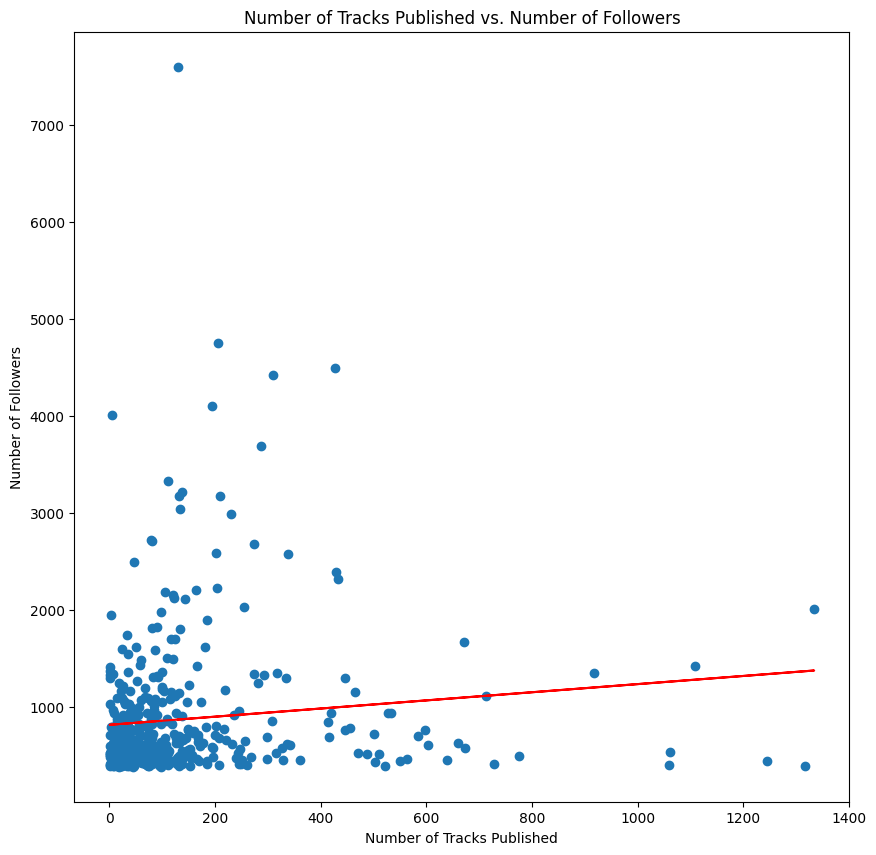

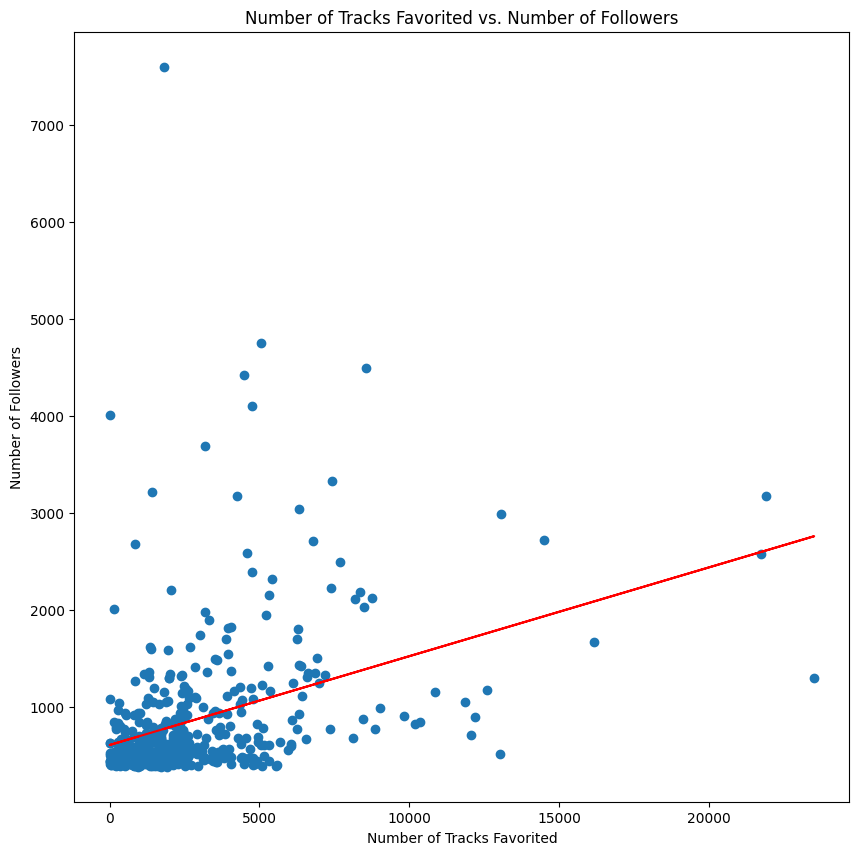

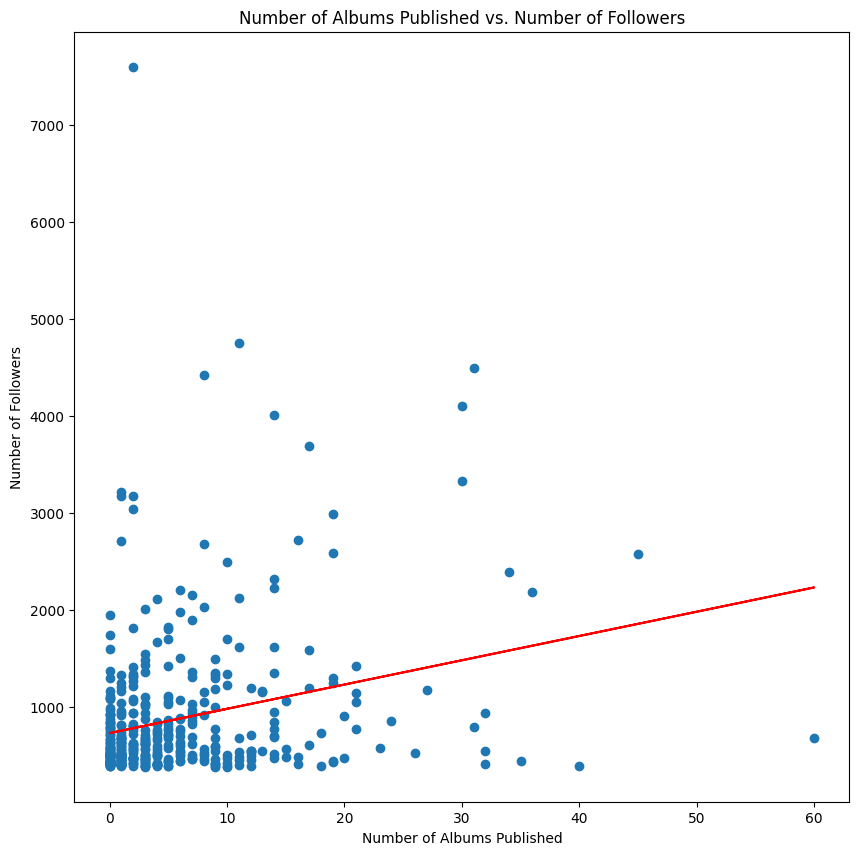

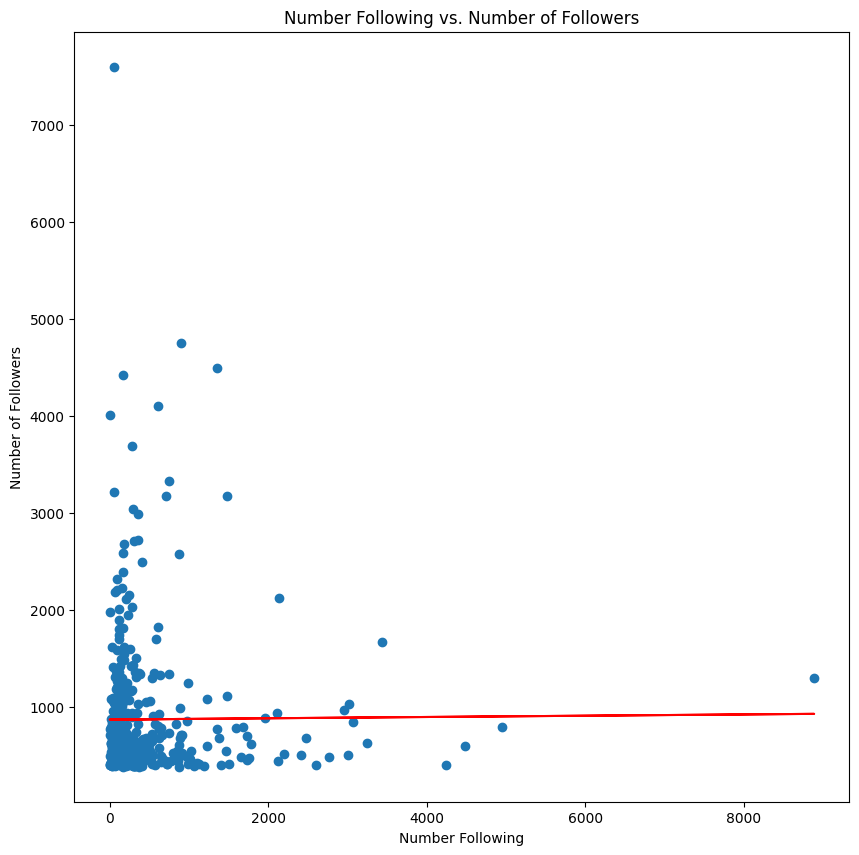

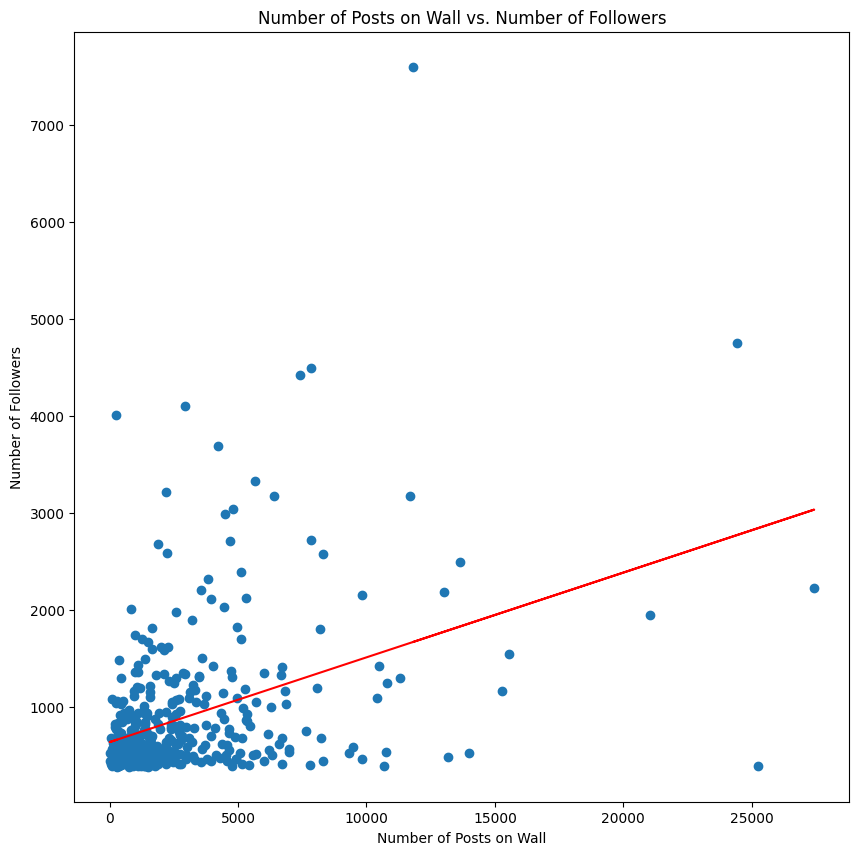

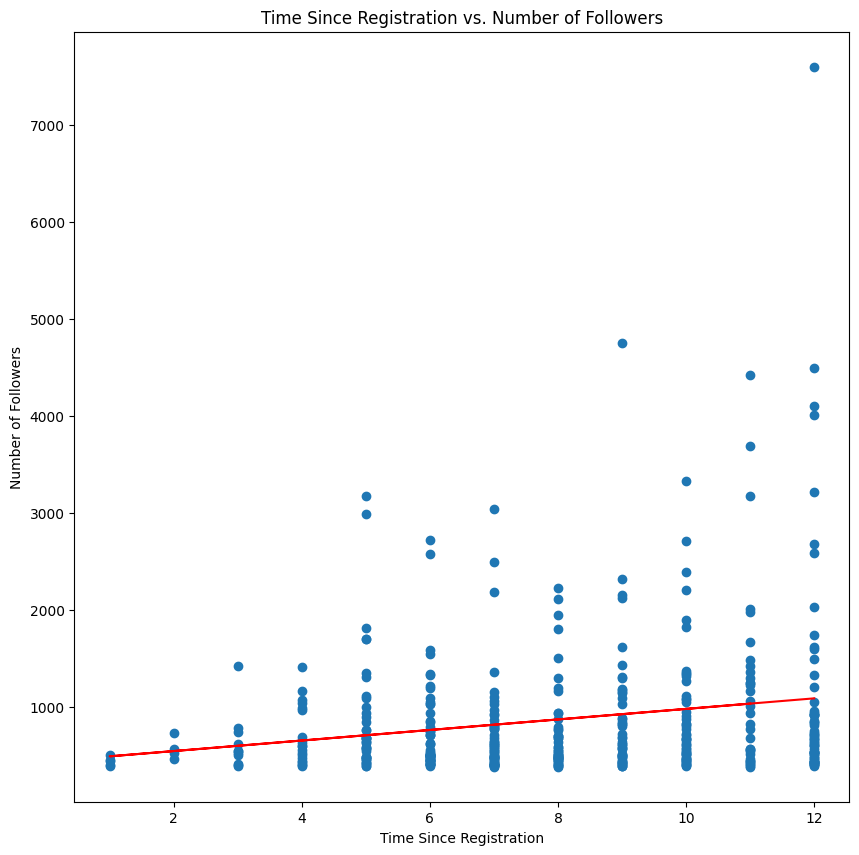

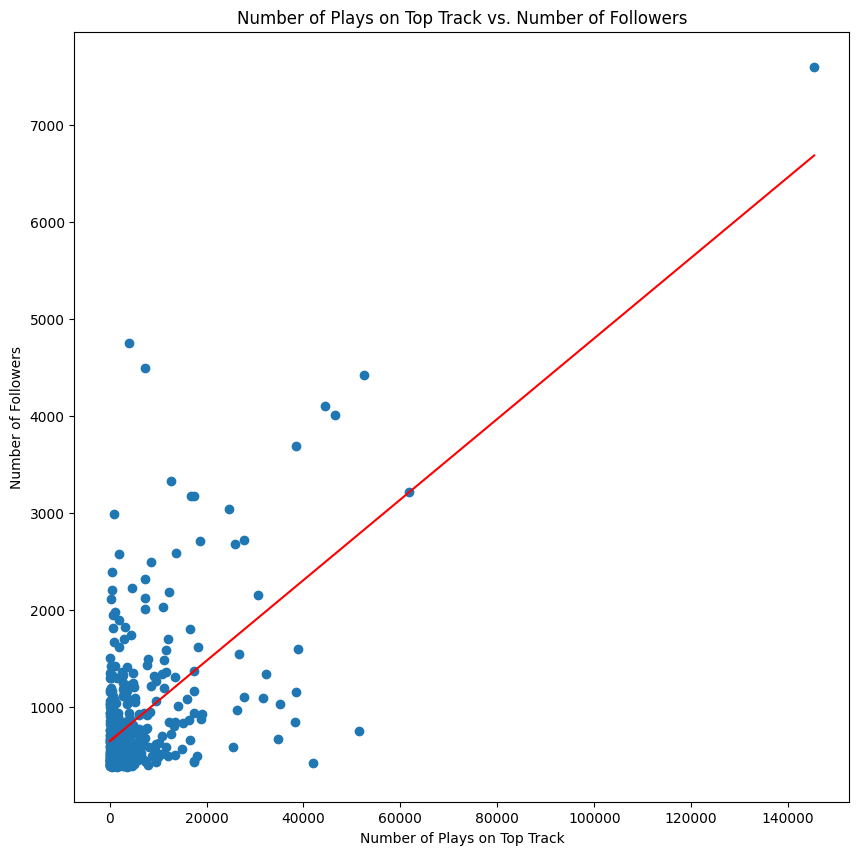

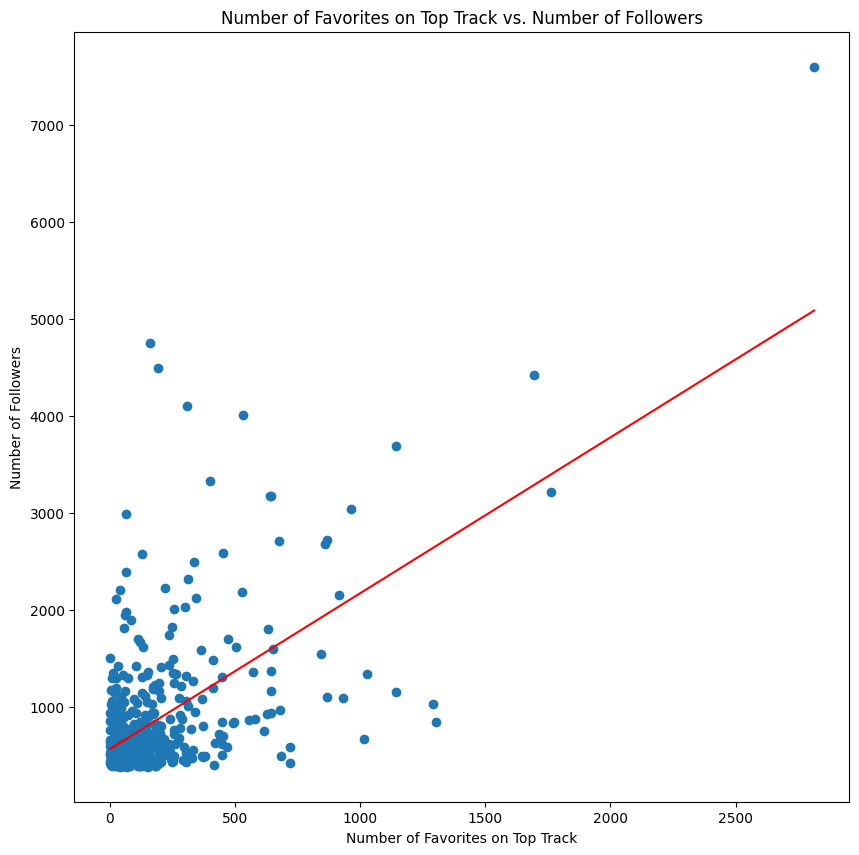

In [48]:
col_names = ["Number of Tracks Published", "Number of Tracks Favorited", "Number of Albums Published", "Number Following", "Number of Posts on Wall", "Time Since Registration", "Number of Plays on Top Track", "Number of Favorites on Top Track", "Genre on Top Track"]
col_ids = ["num_followers",	"num_pub", "num_fav", "num_alb", "num_fol",	"num_wal", "time", "top_plays", "top_favs",	"top_genre"]

y = df['num_followers']
for i in range(len(col_names) - 1):
    
    x = df[col_ids[i+1]]
    a, b = np.polyfit(x, y, 1)

    plt.figure(figsize=(10,10))

    plt.scatter(x, y)
    plt.plot(x, a*x+b, color='r')

    plt.title(f"{col_names[i]} vs. Number of Followers")
    plt.xlabel(f"{col_names[i]}")
    plt.ylabel(f"Number of Followers")
    plt.show()

The cell below shows a heatmap of the variables. Essentially, this shows correlation between each combination of variables. For our purposes, it is most important to look at the top row of the map. This is because we can see what is most correlated to our dependent variable, number of followers. We can ignore the first square because that is looking at the correlation with itself. Otherwise, it seems as if the most strongly correlated features are number of plays on top track and number of favorites on top track. This is logical since more popular music would imply greater traction on the site and therefore greater followers. Number of favorites (number of times the given user favorited another artist's track) and number of posts on wall are also relatively correlated to number of followers. This makes sense because users who interact with others' music are more likely to become known in the community and get followers.

<AxesSubplot: >

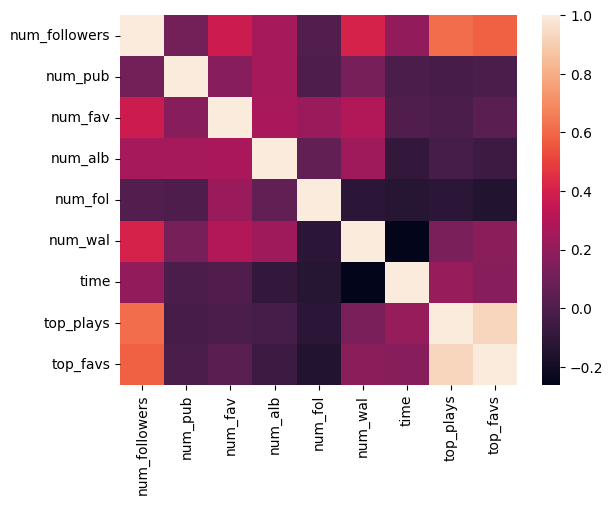

In [106]:
corr = df.corr()
sns.heatmap(corr)

Below, what is generated are cumulative histograms based on the frequencies of each of the independent variables. One thing this indicates about the data is the skew mentioned earlier where much of the data is around the lower end of the range. This explains why there is a steep slope at the beginning that plateus quickly. This means that most data points fall around the beginning of the range and not many at the larger ranges.

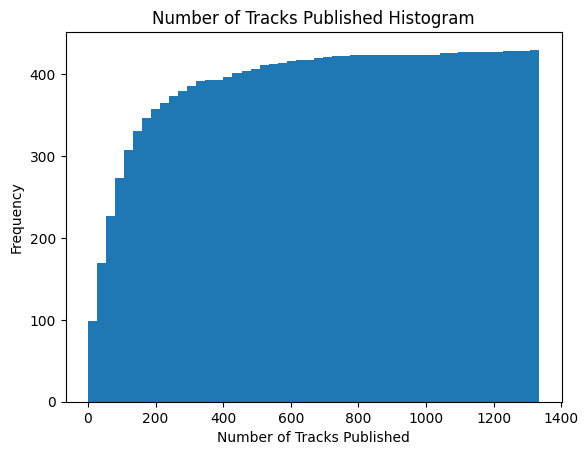

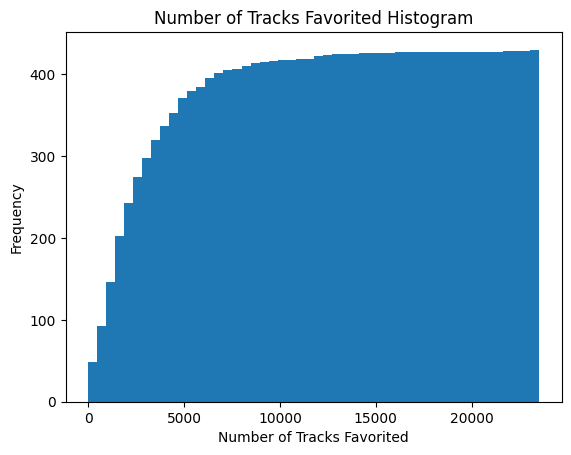

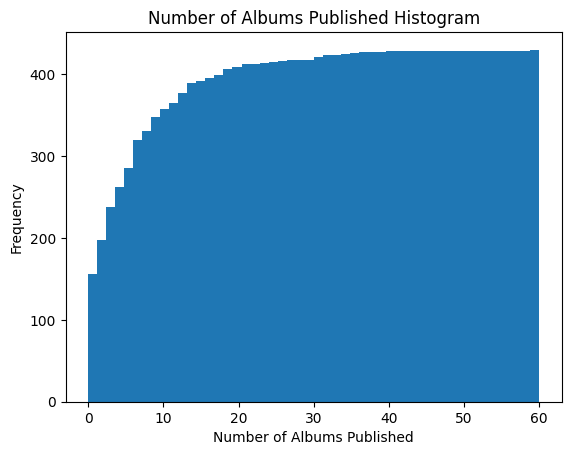

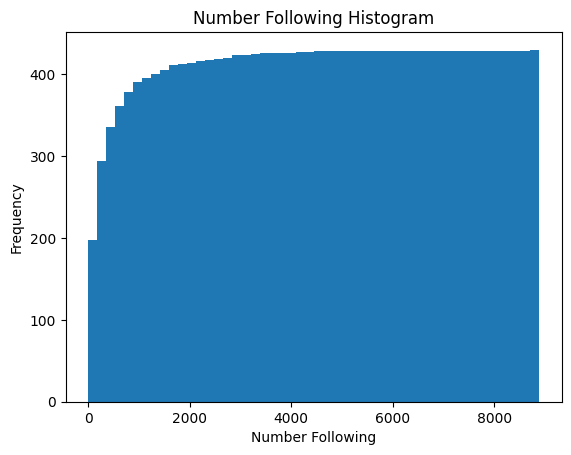

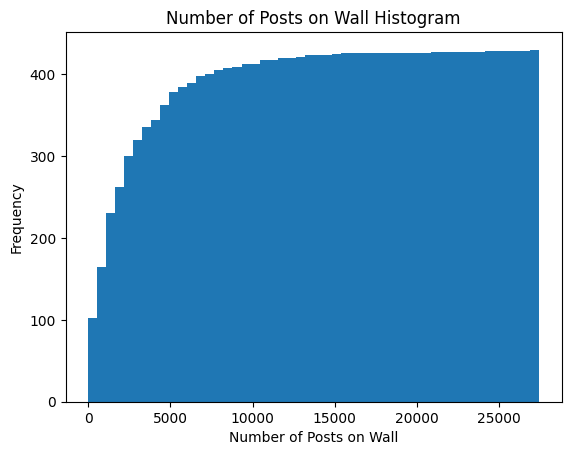

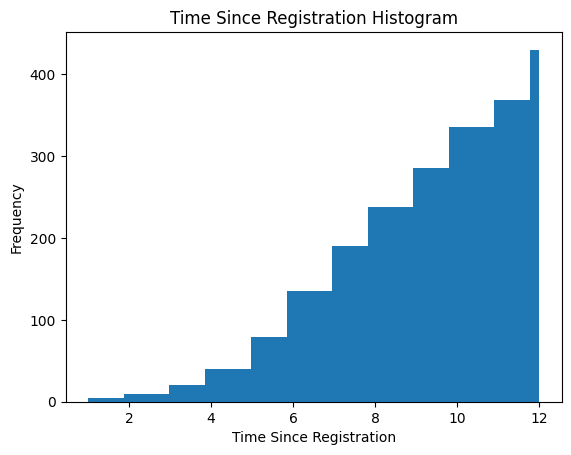

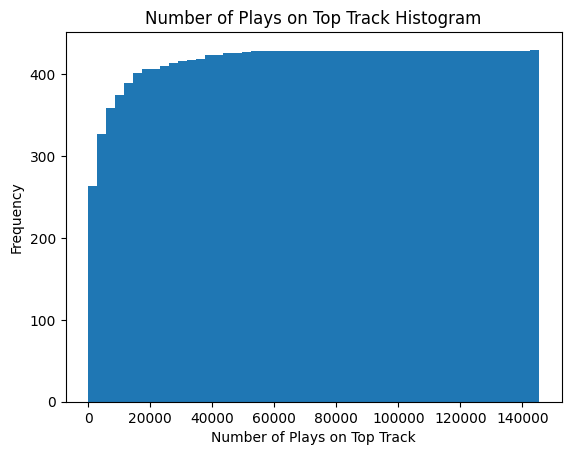

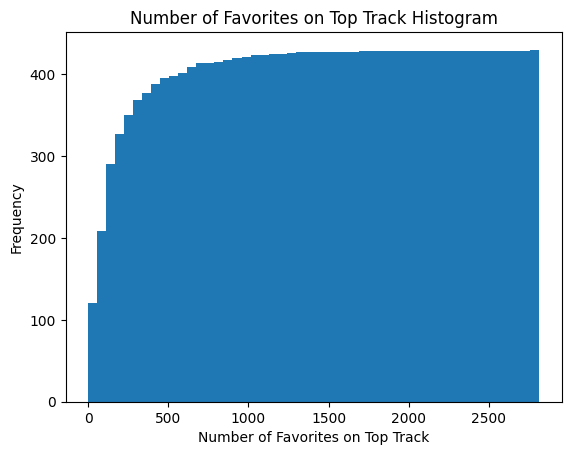

In [107]:
for i in range(len(col_names) - 1):
    
    x = df[col_ids[i+1]]

    plt.hist(x, bins=50, cumulative=True)
    plt.title(f"{col_names[i]} Histogram")

    plt.xlabel(f"{col_names[i]}")
    plt.ylabel(f"Frequency")
    plt.show()

The histogram below finds the frequencies of genre of an artist's top track.  The main thing to note here is the large peak at Uncategorized with another much smaller peak at Trap. The former piece of information is very indicative of a key characteristic that will be mentioned later.

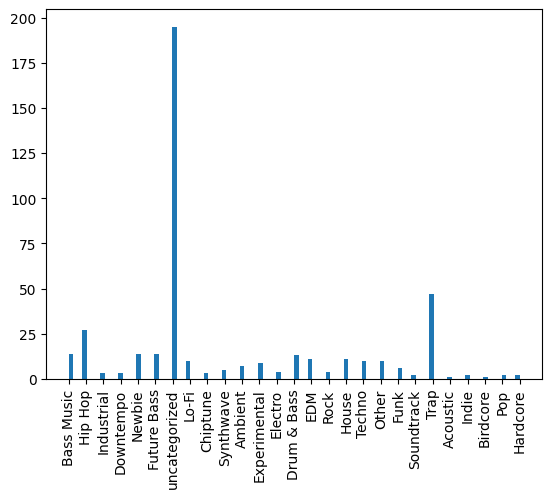

In [113]:
x = df["top_genre"]
plt.hist(x, bins=100)
plt.xticks(rotation=90)
plt.show()

Below, we use Scikit-learn to fit our data to a linear regression model. We first scale the data to make everything within the values of 0 and 1. Next, we split the data by independent and dependent variables, and then fit our data to the model. We can find an R Squared value from this model, and then plot the feature importances (which will be investigated soon).

R Squared Error: 0.6210927503289279


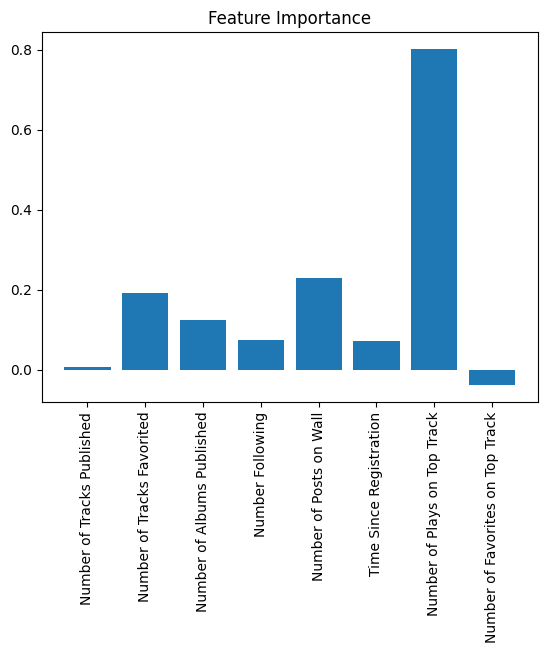

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np

dataset = df.values
min_max_scaler = preprocessing.MinMaxScaler()
scaled_dataset = min_max_scaler.fit_transform(dataset[:,:9])

X = scaled_dataset[:, 1:10]
y = scaled_dataset[:, 0]

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
print("R Squared Error:", r2_score(y, y_pred))

feature_importance = model.coef_
feature_names = ["Number of Tracks Published", "Number of Tracks Favorited", "Number of Albums Published", "Number Following", "Number of Posts on Wall", "Time Since Registration", "Number of Plays on Top Track", "Number of Favorites on Top Track"]

plt.bar(feature_names, feature_importance)
plt.title("Feature Importance")
plt.xticks(fontsize=10, rotation=90)
plt.show()

Below, we use one hot encoding provided by Scikit-learn to convert the top track genre data into data we can use with the linear regression model. This code is below, with a very low R Squared value.

In [105]:
encoder = OneHotEncoder(sparse=False)
X_en = df[['top_genre']]
X_encoded = encoder.fit_transform(X_en)
y = df[['num_followers']]
model = LinearRegression()
model.fit(X_encoded, y)
y_pred = model.predict(X_encoded)
print("R Squared Error:", r2_score(y, y_pred))

R Squared Error: 0.06929621037144107


### Conclusion
The results of fitting to the linear regression model indicated moderately accurate results when attempting to predict follower counts. Based on the feature importance graph, it seems that the feature that can predict follower count the best is number of plays on an artist's top track. This metric essentially implies that if an artist gets more traction and views on their work, then they will amass the most amount of followers. Furthermore, number of posts on wall and number of tracks favorited were relatively high, and seem to indicate that an artist's interaction with other members of the community (beyond just following others) plays a large role in gaining them followers. As mentioned above, the R Squared value with top track genre and follower count was relatively low, meaning low correlation. However, the histogram of frequencies of top tracks indicated that Uncategorized was the most common top track. It is an important fact that Audiotool only relatively recently came out with the genre feature, so many older accounts still have Uncategorized as their top track's genre. It is also important to note that the data scraped here consisted of the top 500 or so top artists, meaning that many top artists have both had their accounts for a long time and made their most popular music at a much earlier date, before genres. This implies a noticeable trend of decreased users on Audiotool over the past several years. However, this adds an extra dimension to the feature important from before, which may tie in length since registration underneath the features already mentioned as being important. Ultimately, the results of this data would indicate that the number of plays on an artist's top track is the most important feature in predicating that artist's follower count.